In [28]:
import icecube
from icecube import icetray, dataio, dataclasses, simclasses,  recclasses, astro, MuonGun
import numpy as np
import sys
import glob
import math
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [29]:
# For using simweight to compute the weight:

sys.path.append("/data/user/tchau/Software/.virtualenvs/DC_self_veto/lib/python3.10/site-packages/")
import simweights

In [30]:
# Some useful functions:

def files(args, include_frames=[], print_file=False):
    """A frame generator that can continue over multiple files"""
    if not isinstance(args, list):
        args = [args]

    for a in args:
        try:
            with dataio.I3File(a) as i3file:
                if print_file: print(f"Opening: {a}")
                for frame in i3file:
                    if len(include_frames) and not frame.Stop.id in include_frames:
                        continue
                    yield frame
        except RuntimeError:
            print(a)
            pass


def DeepCore_cylinder():
    """DeepCore cylinder definition"""

    inner_surface_center = icecube.dataclasses.I3Position(
	        46.29,
	        -34.88,
	        -300,
	    ) * icecube.icetray.I3Units.m
    
    inner_surface = icecube.MuonGun.Cylinder(
        length=500 * icecube.icetray.I3Units.m,
        radius=150 * icecube.icetray.I3Units.m,
        center=inner_surface_center,
        )
    return inner_surface
    
def check_cross_DeepCore(particle):
    """Check if an I3particle cross DeepCore"""

    DC = DeepCore_cylinder()
    inter = DC.intersection(particle.pos, particle.dir).first
    if np.isnan(inter):
        cross = False
    else:
        cross = True
    return cross

# Function related to detector (taken from MESE script)
gcd = '/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_2020.Run134142.Pass2_V0.i3.gz'
###surface for cylinder of partially contained boundary, with 50 meter padding on cylinder top as an extra bin --> this surface_det configuration is DIFFERENT from contained vs. partially contained id, independent of string geometry    
def get_surface_det(gcdFile=None):
    bound_2D=[]
    surface_det = MuonGun.Cylinder(1100,700)   
    t = np.linspace(0, 2 * np.pi, 100)
    surface_det_x = 700 * np.cos(t)
    surface_det_y = 700 * np.sin(t)
    x=[(surface_det_x[i],surface_det_y[i])for i in range(len(surface_det_x))]
    bound_2D= mpltPath.Path(x)#Projection of detector on x,y plane
    return bound_2D, surface_det
    
def boundary_check(particle1,gcdFile=None):
    ####checks if particle is inside the detector###
    gcdFile=gcdFile
    bound_2D,surface_det = get_surface_det(gcdFile=gcdFile)
    cyl_top = 550.
    cyl_bot = -500.
    inlimit = False  
    # print(particle1.pos.z)
    if (((particle1.pos.z <=cyl_top) and (particle1.pos.z>=cyl_bot))) and bound_2D.contains_points([(particle1.pos.x, particle1.pos.y)]):
            inlimit=True            
    return inlimit

def get_lateral_separation(muon, particle2):

    # c = 2.99792458e8 #* I3Units::m / (I3Units::second)
    gamma_muon=muon.energy/0.10566 #MuonMass=105.66MeV/c^2
    p_muon=np.sqrt((muon.energy)**2-(0.10566)**2)/dataclasses.I3Constants.c
    theta=muon.dir.angle(particle2.dir)
    pt_muon=p_muon*np.sin(theta)
    muon_path_length=muon.pos.z/np.cos(muon.dir.zenith)
    lateral_separation=pt_muon*dataclasses.I3Constants.c*muon_path_length/muon.energy
    
    return lateral_separation


# Open files - 22803 sample

In [31]:
# filenamelist = glob.glob('/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0006000-0006999/*.i3.zst')
# filenamelist = glob.glob('/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/*.i3.zst')
# filename = "/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/Level2_IC86.2023_corsika.022803.000000.i3.zst"
filename = "/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst"
# filename = "/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0023000-0023999/IC86.2023_corsika.022803.023000.i3.zst"

In [32]:
#  Try to generate and print some frames
frames = files(filename, print_file=True)
for fr in frames:
    if "I3MCTree" in fr.keys():
        print(fr.keys())
        # print(fr['I3MCTree'])
        mctree = fr['I3MCTree']
        bkg = fr['BackgroundI3MCTree']
        print(bkg)
        for p in bkg:
            # print(p.pdg_encoding)
            if abs(p.pdg_encoding) in [12, 14, 16]:
                parent = bkg.parent(p)
                print(f"{p.shape}, {p.type}, {p.pos.x}, {p.energy}, {parent.type}")
            # break
        break

Opening: /data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst
['BackgroundI3MCPESeriesMapParticleIDMap', 'BackgroundI3MCTree', 'BackgroundI3MCTree_preMuonProp_RNGState', 'BackgroundI3MCTreePEcounts', 'BackgroundMMCTrackList', 'CorsikaWeightMap', 'I3EventHeader', 'I3MCTree', 'TimeShift', 'CorsikaInteractionHeight', 'I3MCTree_preMuonProp', 'I3MCTreePEcounts', 'I3MCTree_preMuonProp_RNGState', 'BackgroundI3MCTree_preMuonProp', 'PolyplopiaPrimary', 'I3MCTree_preSampling', 'BeaconLaunches', 'I3TriggerHierarchy', 'IceTopRawData', 'I3Triggers', 'InIceRawData', 'I3CorsikaInfo', 'MMCTrackList', 'PolyplopiaInfo']
[I3MCTree:
]


In [33]:
def plot_mctree(mctree):
    """
    Plots particles in the mctree based on their z, rho positions and connects them to their parents.

    Args:
        mctree: List of particle objects. Each particle `p` has attributes `pos.x`, `pos.y`, `pos.z`, and a method `mctree.parent(p)` to get its parent.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    for i, p in enumerate(mctree):
        # Extract position
        x, y, z = p.pos.x, p.pos.y, p.pos.z
        # Compute rho
        rho = math.sqrt(x**2 + y**2)
        # Plot the particle's position
        if abs(p.pdg_encoding) in [12, 14, 16]:
            col = 'red'
            lab = 'neutrinos'
            mark = '.'
        elif abs(p.pdg_encoding)==13:
            col = 'blue'
            lab = 'muons'
            mark = '+'
        else:
            col = 'gray'
            lab = 'others'
            mark = '+'
        ax.scatter(rho, z, color=col, s=10, marker = mark, label=lab if lab not in ax.get_legend_handles_labels()[1] else "")
        
        # Get parent particle
        try:
            parent = mctree.parent(p)
            # Extract parent's position
            px, py, pz = parent.pos.x, parent.pos.y, parent.pos.z
            # Compute parent's rho
            parent_rho = math.sqrt(px**2 + py**2)
            # Draw a line connecting particle to its parent
            ax.plot([rho, parent_rho], [z, pz], color='gray', linestyle='--', linewidth=0.8)
        except:
            print(f"particle {p} has no parrent found!")
            continue
    # Labels and title
    ax.set_ylabel("z (position)")
    ax.set_xlabel("rho (sqrt(x^2 + y^2))")
    ax.set_title("MC Tree Particle Visualization")
    ax.legend()
    return ax
        

In [34]:
# take first Mctree encounter
for fr in frames:
    if "I3MCTree" in fr.keys():
        mctree = fr['I3MCTree']
    break

particle [ I3Particle MajorID : 5015628701461841471
             MinorID : 1651
              Zenith : 1.12369
             Azimuth : 4.12074
                   X : -125195
                   Y : -185976
                   Z : 108131
                Time : -818598
              Energy : 3856.75
               Speed : 0.299792
              Length : 223008
                Type : PPlus
        PDG encoding : 2212
               Shape : Primary
              Status : NotSet
            Location : Anywhere
] has no parrent found!
particle [ I3Particle MajorID : 390518187486909862
             MinorID : 473
              Zenith : 0.743336
             Azimuth : 2.28466
                   X : -67487.6
                   Y : 77051.5
                   Z : 111137
                Time : -493792
              Energy : 317747
               Speed : 0.299792
              Length : 123139
                Type : Mg24Nucleus
        PDG encoding : 1000120240
               Shape : Primary
           

(-1000.0, 3000.0)

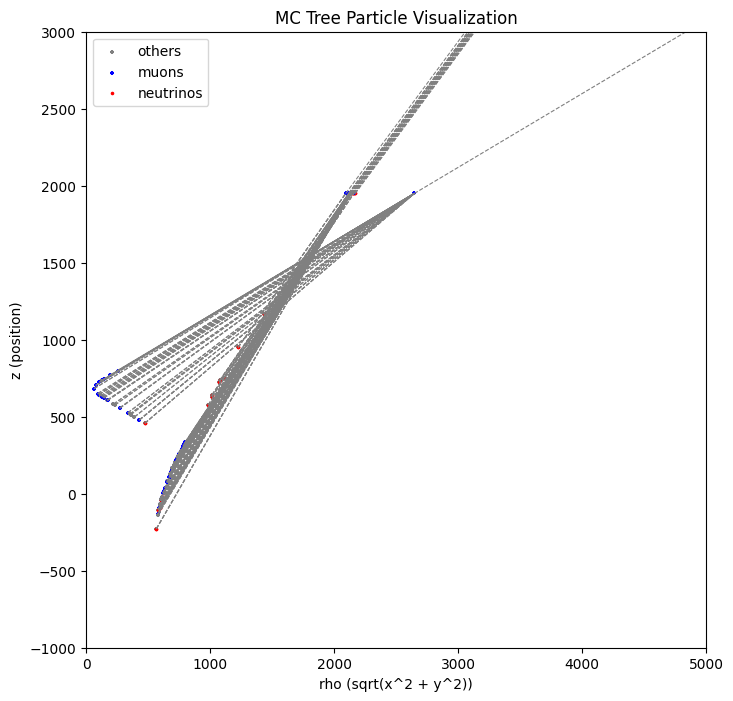

In [35]:
ax = plot_mctree(mctree)
ax.set_xlim(0, 5000)
ax.set_ylim(-1000, 3000)

# Choosing all neutrinos and muons for each I3MCTree (each airshower?)

Store in format list of each entries as 1 airshower: Showers[i] = (dict['nu'], dict['mu])

In [ ]:
# Choose some airshowers, take all the neutrinos + coresponding muons:
Showers = []
bound_2D,surface_det = get_surface_det()
DC = DeepCore_cylinder()

# max and min energy for neutrino
Enu_min = 1
Enu_max = 8000

# Preparation for simweight computation
weight_keys = [
    "CylinderLength",
    "CylinderRadius",
    "EnergyPrimaryMax",
    "EnergyPrimaryMin",
    "NEvents",
    "OverSampling",
    "ParticleType",
    "PrimaryEnergy",
    "PrimarySpectralIndex",
    "PrimaryType",
    "ThetaMax",
    "ThetaMin",
    "Weight",
]

particle_keys = ["type", "energy", "zenith"]

CorsikaWeightMap = {k: [] for k in weight_keys}
PolyplopiaPrimary = {k: [] for k in ["type", "energy", "zenith"]}
MCtype_corsika = np.array([])
MCenergy_corsika = np.array([])

# Loop over frames, selecting neutrino + muons
# filename should always be a list otherwise nfile=len(filename) won't work later on
filename = ["/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst"]
# filename = glob.glob('/data/user/vpalusova/SelfVeto_DeepCore/Corsika_tests/Dataset22803/Dataset_no_cuts/no_cuts_signal/larger_stats/tests/loop/outputs/*/IC86.2023_corsika.*.i3.zst')
# print(filename)
# filename=["/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst",
#             "/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0001000-0001999/IC86.2023_corsika.022803.001000.i3.zst"]

# filename=["/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0000000-0000999/Level2_IC86.2023_corsika.022803.000000.i3.zst",
#             "/data/sim/IceCube/2023/filtered/level2/CORSIKA-in-ice/22803/0001000-0001999/Level2_IC86.2023_corsika.022803.001000.i3.zst"]

# filename.append("/data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst")

frames = files(filename, print_file=True) # could be list of file instead of 1 file!
for fr in frames:
    if "I3MCTree" in fr.keys():
        mctree = fr['I3MCTree']
        primaries = mctree.get_primaries()

        neutrinos = dict()
        neutrinos['energy'] = []
        neutrinos['parent'] = []
        neutrinos['pos'] = []
        neutrinos['zenith'] = []
        neutrinos['azimuth'] = []
        neutrinos['time'] = []
        neutrinos['neutrinos'] = []
        neutrinos['cross_DeepCore'] = []
        neutrinos['is_bkg'] = []
        for p in mctree:
            if abs(p.pdg_encoding) in [12, 14, 16] and p.energy > Enu_min and p.energy < Enu_max:
                neutrinos['energy'].append(p.energy)
                neutrinos['parent'].append(mctree.parent(p))
                neutrinos['pos'].append( (p.pos.x, p.pos.y, p.pos.z) )
                neutrinos['zenith'].append(p.dir.zenith)
                neutrinos['azimuth'].append(p.dir.azimuth)
                neutrinos['time'].append(p.time)
                neutrinos['neutrinos'].append(p)
                neutrinos['cross_DeepCore'].append(check_cross_DeepCore(p))

                # Particles might come from other airshowers
                # This coincidence is simulated using Polyplopia
                # tag a neutrino if it is from primary polyplopia or the coincidence one from other airshower
                if  mctree.get_primary(p) not in primaries:
                    print(f"WARNING, primary not found in list:{mctree.get_primary(p)}")
                elif mctree.get_primary(p)==fr['PolyplopiaPrimary']:
                    neutrinos['is_bkg'].append(0)
                else:
                    neutrinos['is_bkg'].append(1)   
        
        # Take the corresponding muon bundles up to multiplicity 10
        e_muon_total=0
        muon_multiplicity=0
        muon_list=[]
        muon_energy_list=[]
        muons = dict()
        muons['energy_atprod'] = [] # energy at production
        muons['energy_atIC'] = [] # energy at IceCube cylinder (50 meter padding on cylinder top)
        muons['energy_atDC'] = [] # energy at DeepCore cylinder
        muons['parent'] = []
        muons['pos'] = []
        muons['zenith'] = []
        muons['azimuth'] = []
        muons['time'] = []
        muons['muons'] = []
        muons['cross_DeepCore'] = []
        muons['is_bkg'] = []

        for track in MuonGun.Track.harvest(mctree, fr['MMCTrackList']):
            track_energy_at_det=track.get_energy(surface_det.intersection(track.pos, track.dir).first)
            # track_energy_at_det=track.get_energy(DC.intersection(track.pos, track.dir).first)
            # check if muon created inside the cylinder:
            if boundary_check(track): continue

            if track_energy_at_det>1.: # only take muon able to reach the surface
                e_muon_total+=track_energy_at_det
                muon_list.append(track)
                muon_energy_list.append(track_energy_at_det)
                muon_multiplicity+=1
        muons['Total_Muon_Energy'] =e_muon_total
        muons['MuonMultiplicity'] =muon_multiplicity
        sorted_energy_particles=sorted(zip(muon_energy_list, muon_list),reverse=True)

        for energy,muon in sorted_energy_particles:            
            muons['energy_atprod'].append(muon.get_energy(0))
            muons['energy_atIC'].append(muon.get_energy(surface_det.intersection(muon.pos, muon.dir).first))
            muons['energy_atDC'].append(muon.get_energy(DC.intersection(muon.pos, muon.dir).first))

            muons['parent'].append(mctree.parent(muon))
            muons['pos'].append( (muon.pos.x, muon.pos.y, muon.pos.z) )
            muons['zenith'].append(muon.dir.zenith)
            muons['azimuth'].append(muon.dir.azimuth)
            muons['time'].append(muon.time)
            muons['muons'].append(muon)
            muons['cross_DeepCore'].append(check_cross_DeepCore(muon))

            # tag the muons if it is from primary polyplopia or the coincidence one from other airshower
            if  mctree.get_primary(muon) not in primaries:
                print(f"WARNING, primary not found in list:{mctree.get_primary(muon)}")
            elif mctree.get_primary(muon)==fr['PolyplopiaPrimary']:
                muons['is_bkg'].append(0)
            else:
                muons['is_bkg'].append(1)   

        energies = [mu.get_energy(surface_det.intersection(mu.pos, mu.dir).first) for mu in muons['muons']]
        if np.sum(energies) - np.sum(muons['energy_atIC']) > 1e-5:
            print(f"WARNING: muon energy problem: {np.sum(energies)} - {np.sum(muons['energy_atIC'])} > 1e-5")
            print(energies)
            print(muons['energy_atIC'])
        # break        
        # Compute cr weights
        MCtype_corsika = np.append(MCtype_corsika, fr["PolyplopiaPrimary"].type)
        MCenergy_corsika = np.append(MCenergy_corsika, fr["PolyplopiaPrimary"].energy)
        for k in weight_keys:
            CorsikaWeightMap[k].append(fr["CorsikaWeightMap"][k])            
        PolyplopiaPrimary["zenith"].append(fr["PolyplopiaPrimary"].dir.zenith)
        PolyplopiaPrimary["type"].append(fr["PolyplopiaPrimary"].type)
        PolyplopiaPrimary["energy"].append(fr["PolyplopiaPrimary"].energy)
        
        # list of dictionary to store neutrinos and muons info of each shower
        shower = dict()
        shower['CorsikaWeightMap'] = fr['CorsikaWeightMap']
        shower['PolyplopiaPrimary'] = fr['PolyplopiaPrimary']
        shower['primaries'] = primaries
        shower['nu'] = neutrinos
        shower['mu'] = muons
        Showers.append( shower )
        N_shower+=1
    # if N_shower == Nmax: break

# Compute the weights:
fobj = dict(CorsikaWeightMap=CorsikaWeightMap, PolyplopiaPrimary=PolyplopiaPrimary)
wobj = simweights.CorsikaWeighter(fobj, nfiles=len(filename))
print(f"nfile = {len(filename)}")
weights_GaisserH3a = wobj.get_weights(simweights.GaisserH3a())
weights_Hoerandel = wobj.get_weights(simweights.Hoerandel())
print("Finish!")

Opening: /data/sim/IceCube/2023/generated/CORSIKA-in-ice/22803/0000000-0000999/IC86.2023_corsika.022803.000000.i3.zst
nfile = 1
Finish!


# primary spectra

Text(0, 0.5, 'Counts')

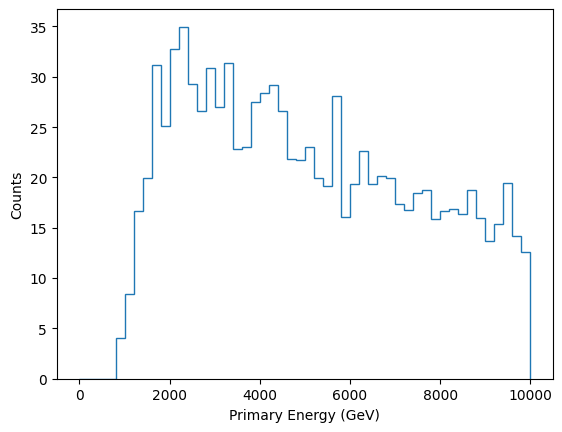

In [198]:
primary_energy = np.array(PolyplopiaPrimary["energy"])
plt.hist(primary_energy, bins=50, range=(0, 10000), histtype='step', label='PolyplopiaPrimary spectra', weights=weights_GaisserH3a)
plt.xlabel("Primary Energy (GeV)")
plt.ylabel("Counts")

2413.808899857757

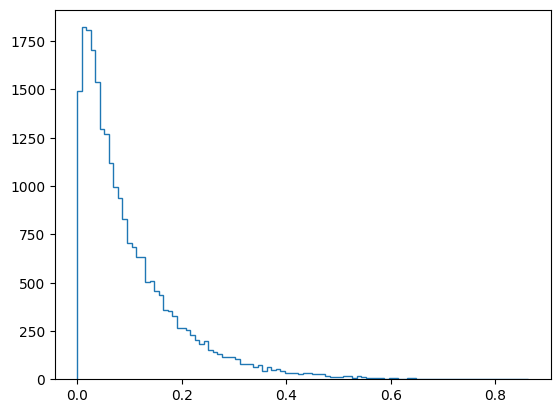

In [199]:
plt.hist(weights_GaisserH3a, bins=100, histtype='step', label='GaisserH3a')
np.sum(weights_GaisserH3a)

# Multiplicities

In [200]:
def plot2d(x, y, bin_count=False, xlabel="x", ylabel='y', zlabel='', title='',
    logx=False, logy=False, **kwargs):
    counts, x_edges, y_edges, im = plt.hist2d(x, y, **kwargs)
    if bin_count:
    # Overlay the bin counts
        for i in range(len(x_edges) - 1):
            for j in range(len(y_edges) - 1):
                # Calculate the position of the text
                x = (x_edges[i] + x_edges[i + 1]) / 2
                y = (y_edges[j] + y_edges[j + 1]) / 2
                # Format the count and add it to the plot
                plt.text(x, y, int(counts[i, j]), color='red', ha='center', va='center', fontsize=8)

    # Plot the 2D histogram
    # plt.hist2d(N_nu, N_mu, cmap='viridis', norm=LogNorm())
    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label=zlabel)
    plt.title(title)
    if logx: plt.semilogx()
    if logy: plt.semilogy()

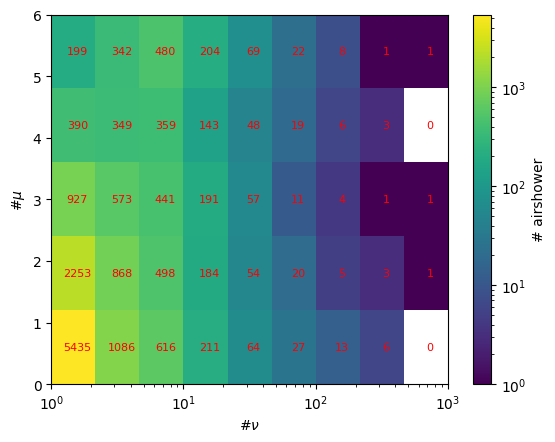

In [201]:
# number of muon, neutrino in airshower
N_mu = []
N_nu = []
for s in Showers:
    loc_nu = np.where(s['nu']['is_bkg']==0 and s["nu"]["cross_DeepCore"])
    loc_mu = np.where(s['mu']['is_bkg']==0 and s["mu"]["cross_DeepCore"])

    N_nu.append(len(s['nu']['neutrinos']))
    N_mu.append(len(s['mu']['muons']))

plot2d(N_nu, N_mu, bin_count=True, xlabel=r'#$\nu$', ylabel=r'#$\mu$', zlabel='# airshower', logx=True,
        bins = [np.logspace(0, 3, 10), np.linspace(0, 6, 6)], norm=LogNorm())

# Functions to extract muons and neutrinos with some conditions

In [202]:
# Energies:
def get_neutrinos(pdg, weight_type, parent=None, is_bkg=0, no_polarization=True
                , cross_DC=False):
    nus = []
    w = []
    for i,s in enumerate(Showers):
        if weight_type == None:
            weight = 1
        elif weight_type == "GaisserH3a":
            weight = weights_GaisserH3a[i]
        elif weight_type == "Hoerandel":
            weight = weights_Hoerandel[i]

        for i, nu in enumerate(s['nu']['neutrinos']):
            if cross_DC and s['nu']['cross_DeepCore'][i]==False:
                continue
            if s['nu']['is_bkg'][i]!=is_bkg: continue

            if no_polarization:
                pdg_encoding = abs(nu.pdg_encoding)
            else:
                pdg_encoding = nu.pdg_encoding

            if pdg_encoding == pdg:
                if parent == None:
                    nus.append(nu)
                    w.append(weight)
                else:
                    if s['nu']['parent'][i].type==parent:
                        nus.append(nu)
                        w.append(weight)
    return np.array(nus), np.array(w)

def get_muons(weight_type, parent=None, is_bkg=0, cross_DC=False, L=1):
    mus = []
    w = []
    for i,s in enumerate(Showers):
        if weight_type == None:
            weight = 1
        elif weight_type == "GaisserH3a":
            weight = weights_GaisserH3a[i]
        elif weight_type == "Hoerandel":
            weight = weights_Hoerandel[i]
        for i, mu in enumerate(s['mu']['muons'][0:L]): # take most L energetic muons
            if cross_DC and s['mu']['cross_DeepCore'][i]==False:
                continue
            # if s['mu']['parent'][i].pdg_encoding in [14,-14]: continue
            if s['mu']['is_bkg'][i]!=is_bkg: continue
                
            if parent == None:
                mus.append(mu)
                w.append(weight)
            else:
                if s['mu']['parent'][i].type==parent:
                    mu.append(mu)
                    w.append(weight)    
    return np.array(mus), np.array(w)

In [203]:
cross_DC = False
# neutrinos
nu_mu, w_numu = get_neutrinos(14, "GaisserH3a", parent=None, is_bkg=0, cross_DC=cross_DC)
nu_e, w_nue = get_neutrinos(12, "GaisserH3a", parent=None, is_bkg=0, cross_DC=cross_DC)
nu_mu_bkg, w_numu_bkg = get_neutrinos(14, "GaisserH3a", parent=None, is_bkg=1, cross_DC=cross_DC)
nu_e_bkg, w_nue_bkg = get_neutrinos(12, "GaisserH3a", parent=None, is_bkg=1, cross_DC=cross_DC)
# neutrino from muon decay
nu_mu_Mu, w_numu_Mu = get_neutrinos(14, "GaisserH3a", parent=dataclasses.I3Particle.ParticleType.MuPlus, is_bkg=0, cross_DC=cross_DC)
nu_e_Mu, w_nue_Mu = get_neutrinos(12, "GaisserH3a", parent=dataclasses.I3Particle.ParticleType.MuPlus, is_bkg=0, cross_DC=cross_DC)
nu_mu_MuMinus, w_numu_MuMinus = get_neutrinos(14, "GaisserH3a", parent=dataclasses.I3Particle.ParticleType.MuMinus, is_bkg=0, cross_DC=cross_DC)
nu_e_MuMinus, w_nue_MuMinus = get_neutrinos(12, "GaisserH3a", parent=dataclasses.I3Particle.ParticleType.MuMinus, is_bkg=0, cross_DC=cross_DC)
nu_mu_Mu = np.append(nu_mu_Mu, nu_mu_MuMinus)
nu_e_Mu = np.append(nu_e_Mu, nu_e_MuMinus)
w_numu_Mu = np.append(w_numu_Mu, w_numu_MuMinus)
w_nue_Mu = np.append(w_nue_Mu, w_nue_MuMinus)
# muons
muons, w_mu = get_muons("GaisserH3a", is_bkg=0, cross_DC=cross_DC)
muons_bkg, w_mu_bkg = get_muons("GaisserH3a", is_bkg=1, cross_DC=cross_DC)

# Energies distribution

In [204]:
# Getting energies of:
#neutrinos from primary
Enu_mu = np.array([nu.energy for nu in nu_mu])
Enu_e = np.array([nu.energy for nu in nu_e])
# neutrino from muon decay
Enu_mu_Mu = np.array([nu.energy for nu in nu_mu_Mu])
Enu_e_Mu = np.array([nu.energy for nu in nu_e_Mu])
#neutrinos from coincidence evt
Enu_mu_bkg = np.array([nu.energy for nu in nu_mu_bkg])
Enu_e_bkg = np.array([nu.energy for nu in nu_e_bkg])
# Muon at production
Emu_prod = np.array([mu.get_energy(0) for mu in muons])
Emu_prod_bkg = np.array([mu.get_energy(0) for mu in muons_bkg])
# Muon at IceCube cylinder
Emu_IC = np.array([mu.get_energy(surface_det.intersection(mu.pos, mu.dir).first) for mu in muons])
Emu_IC_bkg = np.array([mu.get_energy(surface_det.intersection(mu.pos, mu.dir).first) for mu in muons_bkg])

Text(0.5, 1.0, 'weight: GaisserH3a')

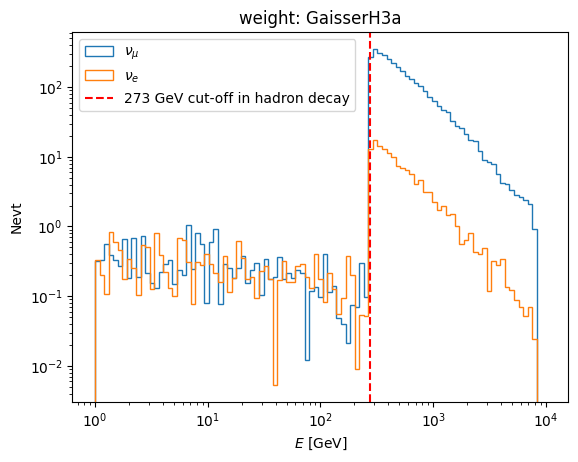

In [205]:
# neutrinos
Ebin = np.logspace(0, 4, 100)
plt.hist(Enu_mu, bins=Ebin, histtype='step', label=r'$\nu_\mu$', weights=w_numu)
plt.hist(Enu_e, bins=Ebin, histtype='step', label=r'$\nu_e$', weights=w_nue)
plt.axvline(273, ls='--', color="red", label='273 GeV cut-off in hadron decay')

plt.legend(loc="upper left")
plt.semilogx()
plt.semilogy()
plt.xlabel(r"$E$ [GeV]")
plt.ylabel("Nevt")
plt.title(f"weight: GaisserH3a")

Text(0.5, 1.0, 'weight: GaisserH3a')

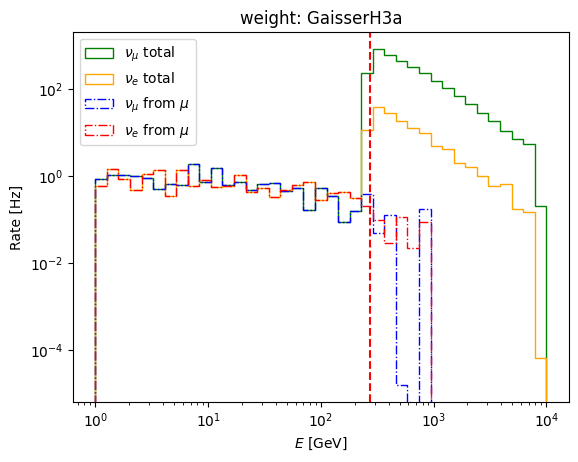

In [206]:
# neutrinos: muon decay vs others
Ebin = np.logspace(0, 4, 40)
plt.hist(Enu_mu, bins=Ebin, histtype='step', label=r'$\nu_\mu$ total', weights=w_numu, color='green')
plt.hist(Enu_e, bins=Ebin, histtype='step', label=r'$\nu_e$ total', weights=w_nue, color='orange')

plt.hist(Enu_mu_Mu, bins=Ebin, histtype='step', label=r'$\nu_\mu$ from $\mu$', weights=w_numu_Mu, color='blue', ls='-.')
plt.hist(Enu_e_Mu, bins=Ebin, histtype='step', label=r'$\nu_e$ from $\mu$', weights=w_nue_Mu, color='red', ls='-.')

plt.legend(loc="upper left")
plt.semilogx()
plt.semilogy()
plt.xlabel(r"$E$ [GeV]")
plt.axvline(273, ls='--', color="red")
plt.ylabel("Rate [Hz]")
plt.title(f"weight: GaisserH3a")

Text(0.5, 1.0, 'weight: GaisserH3a')

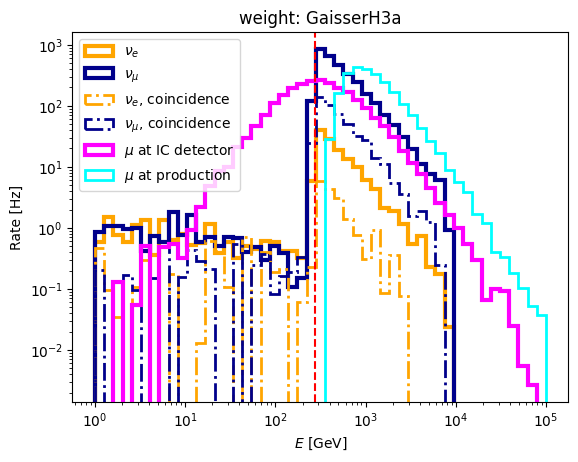

In [207]:
# energy distribution for all:
Ebin = np.logspace(0, 5, 50)
col1 = "orange"
col2 = "darkblue"
colmu = "magenta"
colmu2= "cyan"

plt.hist(Enu_e, bins = Ebin, label=r'$\nu_e$', histtype='step', density=False, lw=3, ls='-', color=col1, weights=w_nue)
plt.hist(Enu_mu, bins = Ebin, label=r'$\nu_\mu$', histtype='step', density=False, lw=3, ls='-', color=col2, weights=w_numu)

plt.hist(Enu_e_bkg, bins = Ebin, label=r'$\nu_e$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col1, weights=w_nue_bkg)
plt.hist(Enu_mu_bkg, bins = Ebin, label=r'$\nu_\mu$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col2, weights=w_numu_bkg)

plt.hist(Emu_IC, bins = Ebin, label=r'$\mu$ at IC detector', histtype='step', density=False, lw=3, color=colmu, weights=w_mu)
plt.hist(Emu_prod, bins = Ebin, label=r'$\mu$ at production', histtype='step', density=False, lw=2, color=colmu2, weights=w_mu)

plt.legend(loc="upper left")
plt.semilogx()
plt.semilogy()
plt.xlabel(r"$E$ [GeV]")
plt.axvline(273, ls='--', color="red")
plt.ylabel("Rate [Hz]")
plt.title(f"weight: GaisserH3a")


# Zenith distributions

In [208]:
# Getting cosine zenith of:
# neutrinos from primary
cosZen_nu_mu = np.array([np.cos(nu.dir.zenith) for nu in nu_mu])
cosZen_nu_e = np.array([np.cos(nu.dir.zenith) for nu in nu_e])
# neutrino from muon decay
cosZen_nu_mu_Mu = np.array([np.cos(nu.dir.zenith) for nu in nu_mu_Mu])
cosZen_nu_e_Mu = np.array([np.cos(nu.dir.zenith) for nu in nu_e_Mu])
# neutrinos from coincidence evt
cosZen_nu_mu_bkg = np.array([np.cos(nu.dir.zenith) for nu in nu_mu_bkg])
cosZen_nu_e_bkg = np.array([np.cos(nu.dir.zenith) for nu in nu_e_bkg])
# Muon at production
cosZen_mu_prod = np.array([np.cos(mu.dir.zenith) for mu in muons])
cosZen_mu_prod_bkg = np.array([np.cos(mu.dir.zenith) for mu in muons_bkg])
# Muon at IceCube cylinder
cosZen_mu_IC = np.array([np.cos(mu.dir.zenith) for mu in muons])
cosZen_mu_IC_bkg = np.array([np.cos(mu.dir.zenith) for mu in muons_bkg])

[]

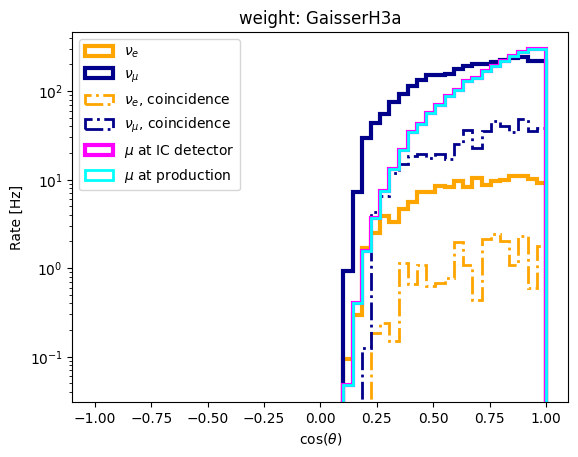

In [209]:
# cosine zenith distribution for all:
Zbin = np.linspace(-1, 1, 50)
col1 = "orange"
col2 = "darkblue"
colmu = "magenta"
colmu2= "cyan"

plt.hist(cosZen_nu_e, bins=Zbin, label=r'$\nu_e$', histtype='step', density=False, lw=3, ls='-', color=col1, weights=w_nue)
plt.hist(cosZen_nu_mu, bins=Zbin, label=r'$\nu_\mu$', histtype='step', density=False, lw=3, ls='-', color=col2, weights=w_numu)

plt.hist(cosZen_nu_e_bkg, bins=Zbin, label=r'$\nu_e$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col1, weights=w_nue_bkg)
plt.hist(cosZen_nu_mu_bkg, bins=Zbin, label=r'$\nu_\mu$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col2, weights=w_numu_bkg)

plt.hist(cosZen_mu_IC, bins=Zbin, label=r'$\mu$ at IC detector', histtype='step', density=False, lw=3, color=colmu, weights=w_mu)
plt.hist(cosZen_mu_prod, bins=Zbin, label=r'$\mu$ at production', histtype='step', density=False, lw=2, color=colmu2, weights=w_mu)

plt.legend(loc="upper left")
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Rate [Hz]")
plt.title(f"weight: GaisserH3a")
plt.semilogy()

[]

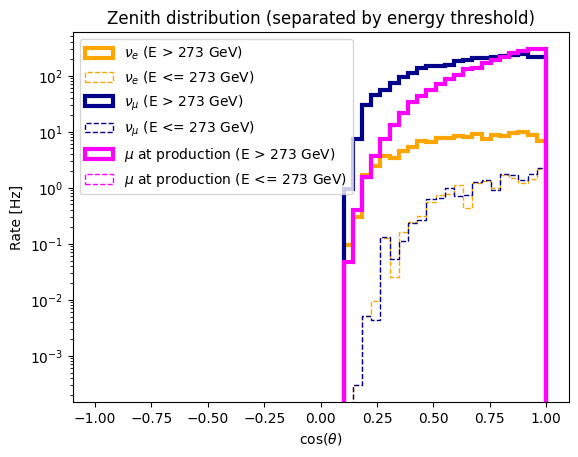

In [210]:
# Separate samples based on energy threshold
threshold = 273  # Energy threshold in GeV

# High energy samples
cosZen_nu_mu_high = cosZen_nu_mu[Enu_mu > threshold]
cosZen_nu_e_high = cosZen_nu_e[Enu_e > threshold]
cosZen_mu_prod_high = cosZen_mu_IC[Emu_prod > threshold]

# Low energy samples
cosZen_nu_mu_low = cosZen_nu_mu[Enu_mu <= threshold]
cosZen_nu_e_low = cosZen_nu_e[Enu_e <= threshold]
cosZen_mu_prod_low = cosZen_mu_IC[Emu_prod <= threshold]

# Plotting
Zbin = np.linspace(-1, 1, 50)
col1 = "orange"
col2 = "darkblue"
colmu = "magenta"

plt.hist(cosZen_nu_e_high, bins=Zbin, label=r'$\nu_e$ (E > 273 GeV)', histtype='step', density=False, lw=3, ls='-', color=col1, weights=w_nue[Enu_e > threshold])
plt.hist(cosZen_nu_e_low, bins=Zbin, label=r'$\nu_e$ (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=col1, weights=w_nue[Enu_e <= threshold])

plt.hist(cosZen_nu_mu_high, bins=Zbin, label=r'$\nu_\mu$ (E > 273 GeV)', histtype='step', density=False, lw=3, ls='-', color=col2, weights=w_numu[Enu_mu > threshold])
plt.hist(cosZen_nu_mu_low, bins=Zbin, label=r'$\nu_\mu$ (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=col2, weights=w_numu[Enu_mu <= threshold])

plt.hist(cosZen_mu_prod_high, bins=Zbin, label=r'$\mu$ at production (E > 273 GeV)', histtype='step', density=False, lw=3, color=colmu, weights=w_mu[Emu_prod > threshold])
plt.hist(cosZen_mu_prod_low, bins=Zbin, label=r'$\mu$ at production (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=colmu, weights=w_mu[Emu_prod <= threshold])

plt.legend(loc="upper left")
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Rate [Hz]")
plt.title(f"Zenith distribution (separated by energy threshold)")
plt.semilogy()

# Z distributions

In [211]:
# Getting z intersection with the IceCube cylinder:
# neutrinos from primary
z_intersection_nu_mu = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_mu])
z_intersection_nu_e = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_e])
# neutrino from muon decay
z_intersection_nu_mu_Mu = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_mu_Mu])
z_intersection_nu_e_Mu = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_e_Mu])
# neutrinos from coincidence evt
z_intersection_nu_mu_bkg = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_mu_bkg])
z_intersection_nu_e_bkg = np.array([nu.pos.z + nu.dir.z * surface_det.intersection(nu.pos, nu.dir).first for nu in nu_e_bkg])
# Muon at production
z_intersection_mu_prod = np.array([mu.pos.z + mu.dir.z * surface_det.intersection(mu.pos, mu.dir).first for mu in muons])
z_intersection_mu_prod_bkg = np.array([mu.pos.z + mu.dir.z * surface_det.intersection(mu.pos, mu.dir).first for mu in muons_bkg])
# Muon at IceCube cylinder
z_intersection_mu_IC = np.array([mu.pos.z + mu.dir.z * surface_det.intersection(mu.pos, mu.dir).first for mu in muons])
z_intersection_mu_IC_bkg = np.array([mu.pos.z + mu.dir.z * surface_det.intersection(mu.pos, mu.dir).first for mu in muons_bkg])

[]

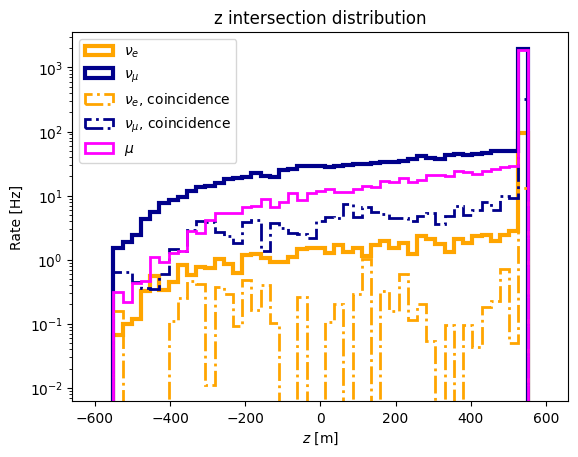

In [212]:
# z intersection distribution for all:
Zbin = np.linspace(-600, 600, 50)
col1 = "orange"
col2 = "darkblue"
colmu = "magenta"

plt.hist(z_intersection_nu_e, bins=Zbin, label=r'$\nu_e$', histtype='step', density=False, lw=3, ls='-', color=col1, weights=w_nue)
plt.hist(z_intersection_nu_mu, bins=Zbin, label=r'$\nu_\mu$', histtype='step', density=False, lw=3, ls='-', color=col2, weights=w_numu)

plt.hist(z_intersection_nu_e_bkg, bins=Zbin, label=r'$\nu_e$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col1, weights=w_nue_bkg)
plt.hist(z_intersection_nu_mu_bkg, bins=Zbin, label=r'$\nu_\mu$, coincidence', histtype='step', density=False, lw=2, ls='-.', color=col2, weights=w_numu_bkg)

plt.hist(z_intersection_mu_prod, bins=Zbin, label=r'$\mu$', histtype='step', density=False, lw=2, color=colmu, weights=w_mu)

plt.legend(loc="upper left")
plt.xlabel(r"$z$ [m]")
plt.ylabel("Rate [Hz]")
plt.title(f"z intersection distribution")
plt.semilogy()

[]

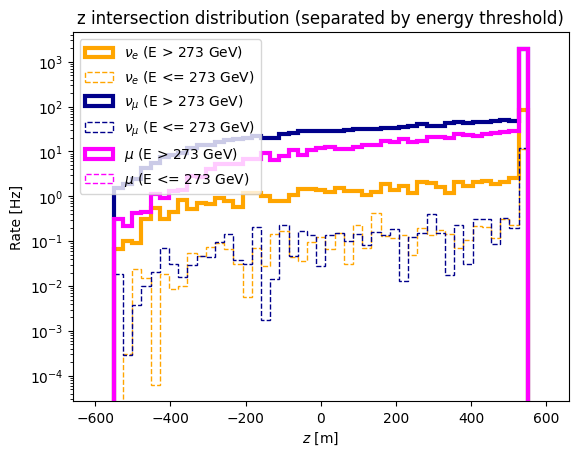

In [213]:
# Separate samples based on energy threshold
threshold = 273  # Energy threshold in GeV

# High energy samples
z_intersection_nu_mu_high = z_intersection_nu_mu[Enu_mu > threshold]
z_intersection_nu_e_high = z_intersection_nu_e[Enu_e > threshold]
z_intersection_mu_prod_high = z_intersection_mu_prod[Emu_prod > threshold]

# Low energy samples
z_intersection_nu_mu_low = z_intersection_nu_mu[Enu_mu <= threshold]
z_intersection_nu_e_low = z_intersection_nu_e[Enu_e <= threshold]
z_intersection_mu_prod_low = z_intersection_mu_prod[Emu_prod <= threshold]

# Plotting
Zbin = np.linspace(-600, 600, 50)
col1 = "orange"
col2 = "darkblue"
colmu = "magenta"

plt.hist(z_intersection_nu_e_high, bins=Zbin, label=r'$\nu_e$ (E > 273 GeV)', histtype='step', density=False, lw=3, ls='-', color=col1, weights=w_nue[Enu_e > threshold])
plt.hist(z_intersection_nu_e_low, bins=Zbin, label=r'$\nu_e$ (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=col1, weights=w_nue[Enu_e <= threshold])

plt.hist(z_intersection_nu_mu_high, bins=Zbin, label=r'$\nu_\mu$ (E > 273 GeV)', histtype='step', density=False, lw=3, ls='-', color=col2, weights=w_numu[Enu_mu > threshold])
plt.hist(z_intersection_nu_mu_low, bins=Zbin, label=r'$\nu_\mu$ (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=col2, weights=w_numu[Enu_mu <= threshold])

plt.hist(z_intersection_mu_prod_high, bins=Zbin, label=r'$\mu$ (E > 273 GeV)', histtype='step', density=False, lw=3, color=colmu, weights=w_mu[Emu_prod > threshold])
plt.hist(z_intersection_mu_prod_low, bins=Zbin, label=r'$\mu$ (E <= 273 GeV)', histtype='step', density=False, lw=1, ls='--', color=colmu, weights=w_mu[Emu_prod <= threshold])

plt.legend(loc="upper left")
plt.xlabel(r"$z$ [m]")
plt.ylabel("Rate [Hz]")
plt.title(f"z intersection distribution (separated by energy threshold)")
plt.semilogy()

# 2D distribution

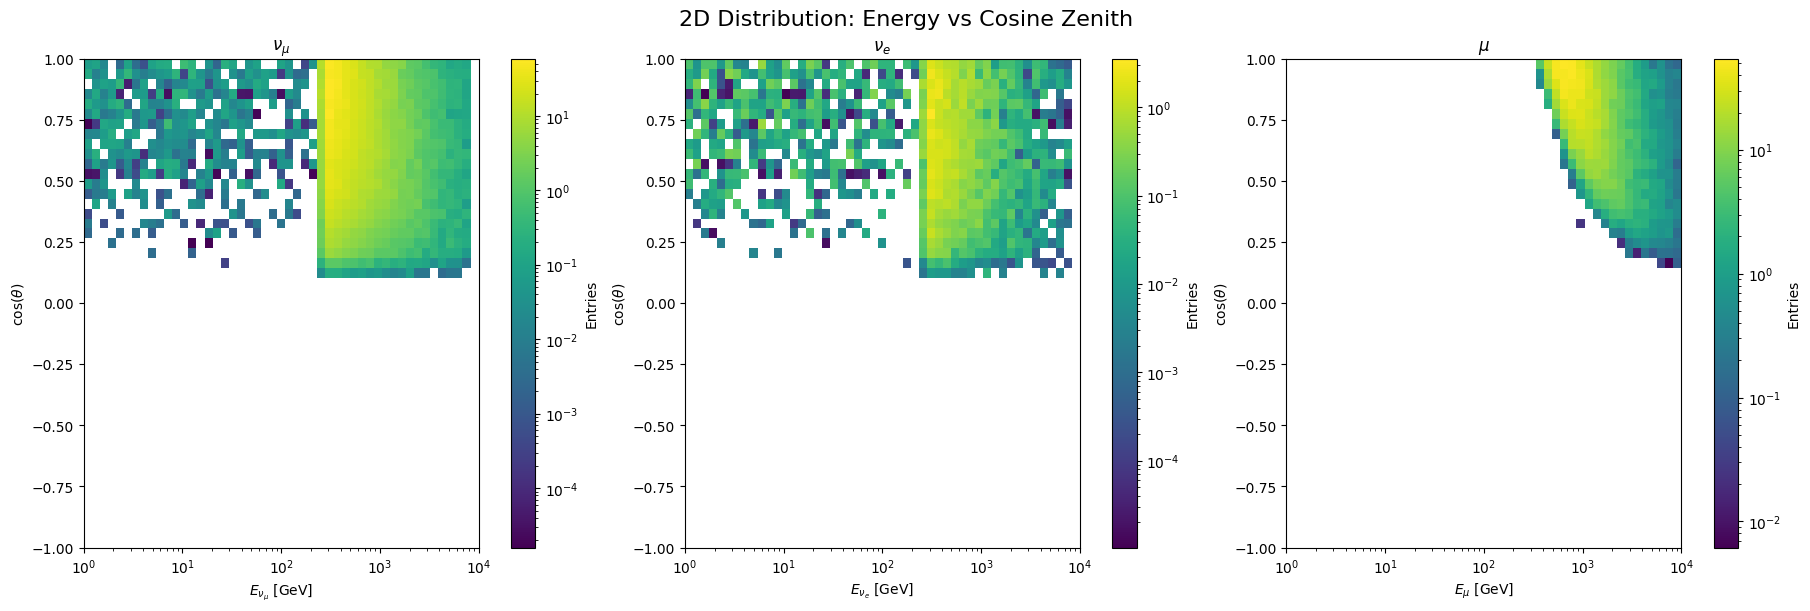

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Define bins
Ebin = np.logspace(0, 4, 50)
Zbin = np.linspace(-1, 1, 50)
bins = [Ebin, Zbin]

# numu
counts, x_edges, y_edges, im = axes[0].hist2d(Enu_mu, cosZen_nu_mu, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_numu)
axes[0].set_title(r"$\nu_\mu$")
axes[0].set_xlabel(r"$E_{\nu_\mu}$ [GeV]")
axes[0].set_ylabel(r"$\cos(\theta)$")
axes[0].set_xscale('log')
fig.colorbar(im, ax=axes[0], label="Entries")

# nue
counts, x_edges, y_edges, im = axes[1].hist2d(Enu_e, cosZen_nu_e, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_nue)
axes[1].set_title(r"$\nu_e$")
axes[1].set_xlabel(r"$E_{\nu_e}$ [GeV]")
axes[1].set_ylabel(r"$\cos(\theta)$")
axes[1].set_xscale('log')
fig.colorbar(im, ax=axes[1], label="Entries")

# muon
counts, x_edges, y_edges, im = axes[2].hist2d(Emu_prod, cosZen_mu_prod, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_mu)
axes[2].set_title(r"$\mu$")
axes[2].set_xlabel(r"$E_{\mu}$ [GeV]")
axes[2].set_ylabel(r"$\cos(\theta)$")
axes[2].set_xscale('log')
fig.colorbar(im, ax=axes[2], label="Entries")

plt.suptitle("2D Distribution: Energy vs Cosine Zenith", fontsize=16)
plt.show()

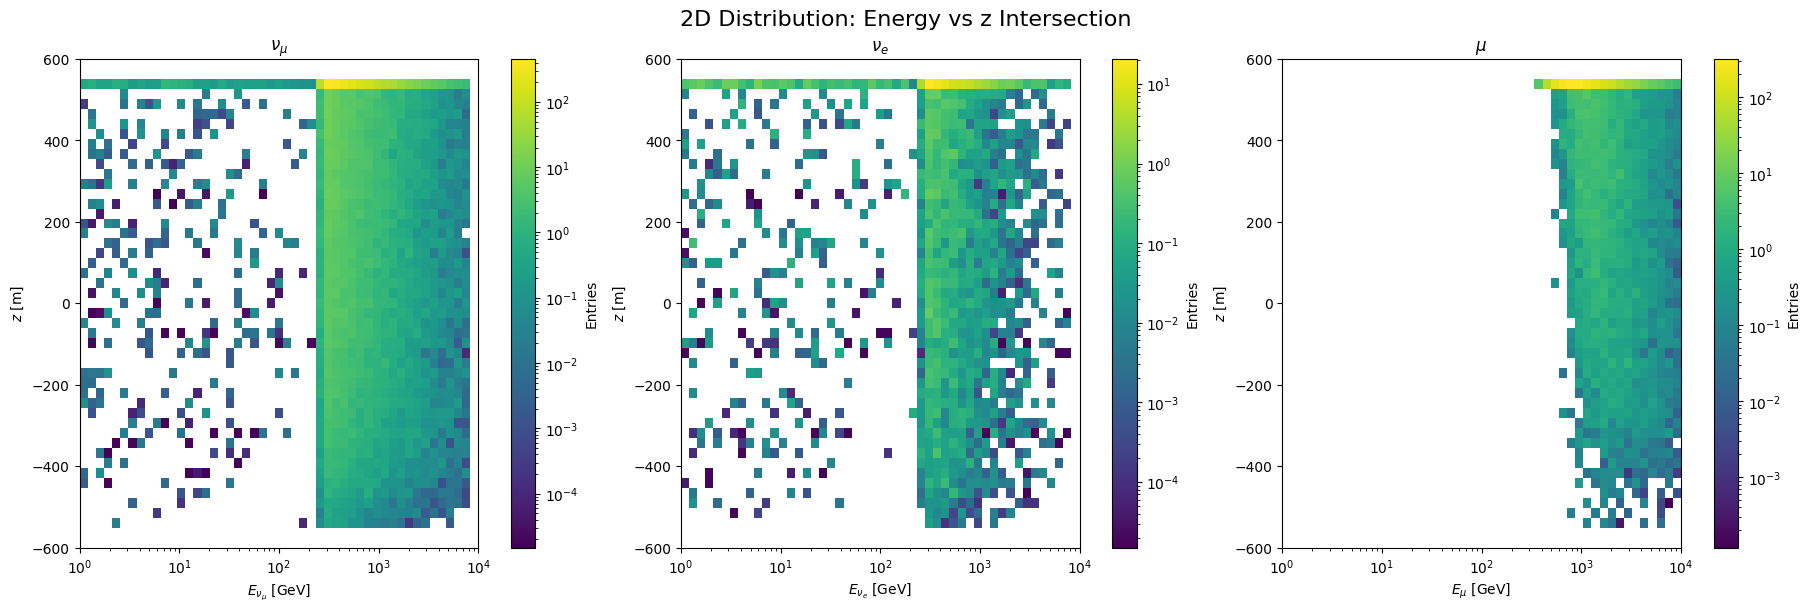

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Define bins
Ebin = np.logspace(0, 4, 50)
Zbin = np.linspace(-600, 600, 50)
bins = [Ebin, Zbin]

# numu
counts, x_edges, y_edges, im = axes[0].hist2d(Enu_mu, z_intersection_nu_mu, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_numu)
axes[0].set_title(r"$\nu_\mu$")
axes[0].set_xlabel(r"$E_{\nu_\mu}$ [GeV]")
axes[0].set_ylabel(r"$z$ [m]")
axes[0].set_xscale('log')
fig.colorbar(im, ax=axes[0], label="Entries")

# nue
counts, x_edges, y_edges, im = axes[1].hist2d(Enu_e, z_intersection_nu_e, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_nue)
axes[1].set_title(r"$\nu_e$")
axes[1].set_xlabel(r"$E_{\nu_e}$ [GeV]")
axes[1].set_ylabel(r"$z$ [m]")
axes[1].set_xscale('log')
fig.colorbar(im, ax=axes[1], label="Entries")

# muon
counts, x_edges, y_edges, im = axes[2].hist2d(Emu_prod, z_intersection_mu_prod, bins=bins, norm=LogNorm(), cmap='viridis', weights=w_mu)
axes[2].set_title(r"$\mu$")
axes[2].set_xlabel(r"$E_{\mu}$ [GeV]")
axes[2].set_ylabel(r"$z$ [m]")
axes[2].set_xscale('log')
fig.colorbar(im, ax=axes[2], label="Entries")

plt.suptitle("2D Distribution: Energy vs z Intersection", fontsize=16)
plt.show()

# Colinear check

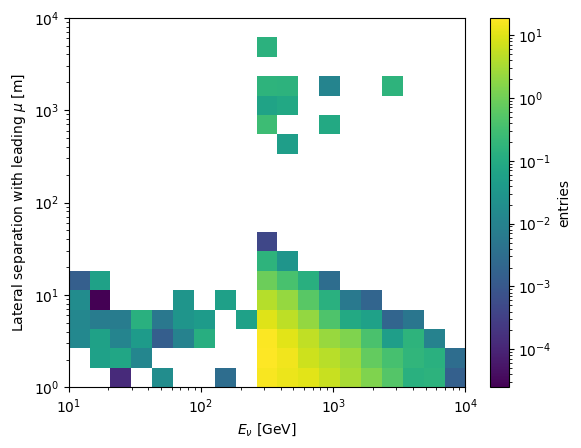

In [216]:
def separation_at_det(particle1, particle2, det_cylinder):
    # check if the particles cross the detector and take the intersection point
    inter1 = det_cylinder.intersection(particle1.pos, particle1.dir).first
    inter2 = det_cylinder.intersection(particle2.pos, particle2.dir).first
    if np.isnan(inter1) or np.isnan(inter2):
        return np.nan
    else:
        # If intersection exists, compute the intersection point
        end_x1 = particle1.pos.x + inter1 * particle1.dir.x
        end_y1 = particle1.pos.y + inter1 * particle1.dir.y
        end_z1 = particle1.pos.z + inter1 * particle1.dir.z

        end_x2 = particle2.pos.x + inter2 * particle2.dir.x
        end_y2 = particle2.pos.y + inter2 * particle2.dir.y
        end_z2 = particle2.pos.z + inter2 * particle2.dir.z

        return np.sqrt((end_x1-end_x2)**2+(end_y1-end_y2)**2+(end_z1-end_z2)**2)


def angular_separation(particle1, particle2):
    return particle1.dir.angle(particle2.dir)

def hist_Enu_lateral(L=1, lateral_max=10000000, coincidence_mode=2, cross_DC=False):
    lateral = []
    nu_energy = []
    weight = []
    for i, s in enumerate(Showers):
        w = weights_GaisserH3a[i]
        muons = s['mu']['muons']
        if len(muons)<= L-1: continue
        #coincidence_mode: 0: take all, 1: only from polypopia primary, 2: take from 2 different air showers
        if coincidence_mode==1 and s['mu']['is_bkg'][L-1]==1: continue
        for i, nu in enumerate(s['nu']['neutrinos']):
            if coincidence_mode==1 and s['nu']['is_bkg'][i]==1: continue
            if coincidence_mode==2 and s['nu']['is_bkg'][i]==0: continue

            if cross_DC:
                if not s['nu']['cross_DeepCore'][i]: continue
                if not s['mu']['cross_DeepCore'][L-1]: continue
                if s['mu']['energy_atDC'][L-1]<=0: continue

            # l = separation_at_det(muons[L-1], nu, DeepCore_cylinder())
            # l = angular_separation(nu, muons[L-1])
            l = get_lateral_separation(muons[L-1], nu)
            if l>lateral_max: continue
            nu_energy.append(nu.energy)
            lateral.append(l)
            weight.append(w)
    return nu_energy, lateral, weight

Enu, lateralL1, weight = hist_Enu_lateral(L=1, coincidence_mode=0, cross_DC=True)
plot2d(Enu, lateralL1, xlabel=r'$E_{\nu}$ [GeV]', ylabel=r'Lateral separation with leading $\mu$ [m]', zlabel='entries', norm=LogNorm(),
        bins=[np.logspace(1, 4, 20), np.logspace(0, 4, 20)], logx=True, logy=True, title='', weights = weight)

# plot2d(Enu, lateralL1, xlabel=r'$E_{\nu}$ [GeV]', ylabel=r'angular separation [rad]', zlabel='entries', norm=LogNorm(),
#         bins=[np.logspace(1, 4, 20), np.logspace(-2, 1, 20)], logx=True, logy=True, title='only primary', weights = weight)